## Define Needed Functions

### Import Needed Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import networkx as nx
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
import ssl

### Import Sentiment Analysis lexicon

For this project the nltk vader lexicon was used for sentiment analysis

In [ ]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon')

### Data Cleaning Functions

Two cleaning functions were used on the data: one to simply check if the text is in ascii charaters to filter out arabic text in the data set, the other to remove stop words and lemmas (suffixes and prefixes). 

In [ ]:
def is_ascii(s):
    """
    Checks if a string only contains ascii charaters
    
    Parameters
    ----------
    s: string
        A given string
        
    Returns
    -------
    Bool
        If the string contains only ascii characters, return true, else false
    
    """
    return all(ord(c) < 128 for c in s)

nlp = spacy.load("en_core_web_sm")
def cleanData(messages):
    """
    removes stop words and stems words in a sentence 
    
    Parameters
    ----------
    message: string
        A given message
        
    Returns
    -------
    string
       cleaned string
    
    """
    
    for i in range(0,len(messages)):
        try:
            doc = nlp(messages.iloc[i])
            token_list = [token for token in doc]
            filtered_tokens = [token for token in doc if not token.is_stop]
            lemmas = [token.lemma_ for token in filtered_tokens]
            s = ' '.join(lemmas)
            
            messages.iloc[i] = s
        except:
            messages.iloc[i] = ""
        
        #if is_ascii(messages.iloc[i]) == False:
             #messages.iloc[i] = ""

    return messages

### Sentiment Analysis Functions

Two sentiment analysis functions also exist. The first gets the sentiment of a single sentance/string and the other uses the former to loop over a document to get a mean sentiment

In [ ]:
sia = SentimentIntensityAnalyzer()
def getSentiment(message):
    """
    Gets sentiment of a message using the vader lexicon
    
    Parameters
    ----------
    message: string
        A given message
        
    Returns
    -------
    float
        Sentiment score between -1 and 1
    
    """
    return  sia.polarity_scores(message)['compound']

def getAllSentiment(thread):
    """
    Gets mean sentiment of all messages in a thread using the getSentiment function
    
    Parameters
    ----------
    Thread: List
        list of all messages in a given thread
        
    Returns
    -------
    float
        Sentiment score between -1 and 1
    
    """
    messages = thread["Message"].copy()
    clean = cleanData(messages)
    sentiment = []
    for i in clean:
        sentiment.append(getSentiment(i))
    
    return np.mean(sentiment)

## Make Graph

### Loading in the Data

To start making a graph we must read in our given data and pick out the individual threads in the online forum

In [ ]:
data = pd.read_csv("CleanData/GawaherClean.csv", index_col=0)
threads = data["ThreadID"].unique()

### Creating nodes and edges

Next, we have to create the nodes and edges for the graph. The sentiment of each thread is taken to get node values and edges are created by finding threads with common memembers. The edges are weighted by the number of shared members between threads.

In [7]:
sentiments = pd.read_csv("sentimentData.csv")
sentiments.head()

,thread,sentiment
0,240.0,0.260647
1,2583.0,0.418658
2,533029.0,-0.038381
3,10096.0,0.316037
4,9186.0,0.006380


In [10]:
"""
sentiments = []

for i in range(0,len(threads)):
    thread = data[data["ThreadID"]== threads[i]]
    sentiments.append(getAllSentiment(thread))
"""

    

nodeDict = dict(zip(sentiments["thread"].to_numpy(dtype = int),np.around(sentiments["sentiment"].to_numpy(),4)))

In [13]:
edges = []
weights = []
for i in range(0,len(threads)):
    for j in range(0, len(threads)):
        if i >= j:
            pass
        else:
            thread1 = data[data["ThreadID"] == threads[i]]["MemberID"]
            thread2 = data[data["ThreadID"] == threads[j]]["MemberID"]
            intersection = len(np.intersect1d(thread1,thread2))
            if intersection > 0:
                edges.append([threads[i],threads[j]])
                weights.append(intersection)

## Creating and plotting Graph

The the nodes and edges, networkX can create and plot the graph 

In [14]:
G = nx.Graph()
G.add_nodes_from(threads)
G.add_edges_from(edges)
edgeDict = dict(zip(G.edges,weights))

plt.figure(figsize = (12,12))
pos=nx.spring_layout(G)
nx.draw(G,pos, labels = nodeDict, with_labels=True, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edgeDict, label_pos=0.5, font_size = 12);


Error in callback <function flush_figures at 0x7fd133217790> (for post_execute):


KeyboardInterrupt: 

## Get Statistics

With the graph made, statistics can be taken from it. Specifically, this code is going to look at if similarly sentimented threads are connected to each other.

A connectivity function was created to take in sentiments between nodes and edge weights to calculated weighted and unweighted connectivity.

In [24]:
def connectivity(edgeSentiments,weights):
    """
    Gets all connections between threads in forum data set
    
    Parameters
    ----------
    edgeSentiments: List
        A list of sentiments on each end of an edge [[sentiment, sentiment],[sentiment, sentiment]...]
    
    weights: List
        List of all edge weights
        
    Returns
    -------
    ints
        number of positve-postive, negative-negative, and positive-negative connections
    
    """
    
    posPos = 0
    negNeg = 0
    posNeg = 0
    
    index = 0
    for pair in edgeSentiments:
        if np.sign(pair[0]) == np.sign(pair[1]) and np.sign(pair[0]) == 1:
            posPos += 1*weights[index]
        elif np.sign(pair[0]) == np.sign(pair[1]) and np.sign(pair[0]) == -1:
            negNeg += 1*weights[index]
        elif np.sign(pair[0]) != np.sign(pair[1]) and pair[0] != 0 and pair[1] != 0:
            posNeg += 1*weights[index]
        index += 1
    return posPos,negNeg, posNeg



In [18]:
flatEdges = np.concatenate(edges)
flatSentiments = np.array([nodeDict[x] for x in flatEdges])
edgeSentiments = np.sort(flatSentiments.reshape(-1,2))
uniqueWeights = np.full(len(weights),1)
 
allConnection = list(connectivity(edgeSentiments,weights))
uniqueConnection = list(connectivity(edgeSentiments,uniqueWeights))

### Visualize Statistics

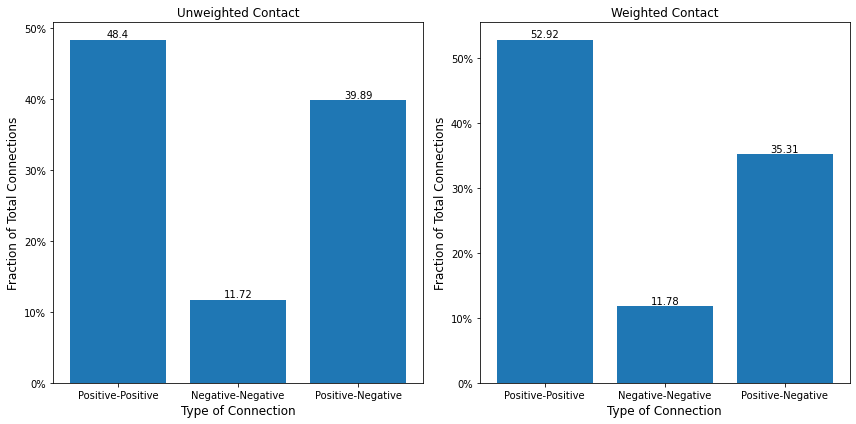

In [19]:
plt.figure(figsize = (12,6))

plt.subplot(1,2,2)

plot1 = plt.bar(["Positive-Positive","Negative-Negative","Positive-Negative"],allConnection/np.sum(allConnection))
plt.title("Weighted Contact", fontsize = 12)
plt.ylabel("Fraction of Total Connections", fontsize = 12)
plt.xlabel("Type of Connection", fontsize = 12)
plt.bar_label(plot1,np.around(np.array(allConnection)*100/np.sum(allConnection),2))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))


plt.subplot(1,2,1)
plot2 = plt.bar(["Positive-Positive","Negative-Negative","Positive-Negative"],uniqueConnection/np.sum(uniqueConnection))
plt.title("Unweighted Contact", fontsize = 12)
plt.ylabel("Fraction of Total Connections", fontsize = 12)
plt.xlabel("Type of Connection", fontsize = 12)
plt.bar_label(plot2,np.around(np.array(uniqueConnection)*100/np.sum(uniqueConnection),2))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.tight_layout()
plt.savefig("interThread.png")